In [6]:
import numpy as np
from scipy.sparse import vstack
import pandas as pd
from sklearn import metrics
import matplotlib.pyplot as plt

import re
import os
import random
import copy
from tqdm import tqdm


import torch
import torch.nn as nn
import torch.nn.functional as F

from torchtext.data import TabularDataset, Dataset, Example, Field, BucketIterator
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, accuracy_score, precision_score, recall_score, roc_auc_score
import pytorch_lightning as pl
from pytorch_lightning import Trainer, seed_everything
from pytorch_lightning.core.lightning import LightningModule
from pytorch_lightning.loggers.neptune import NeptuneLogger

from pytorch_lightning.callbacks.early_stopping import EarlyStopping
from pytorch_lightning.callbacks import ModelCheckpoint
# from neptunecontrib.monitoring.metrics import log_roc_auc, log_classification_report
from sklearn.linear_model import LogisticRegression

import scikitplot as skplt

import nltk
nltk.download('punkt')

from bpemb import BPEmb
# from transformers import BertConfig, BertTokenizer, BertModel
# from transformers.optimization import AdamW
import scipy
import wrappers

[nltk_data] Downloading package punkt to /home/artem/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [7]:
from xgboost import XGBClassifier

In [8]:
import torch
from torch import nn, optim
import torch.nn.functional as F
from torch.utils.data import DataLoader, RandomSampler
from pytorch_lightning.callbacks.early_stopping import EarlyStopping
from pl_bolts.datamodules.async_dataloader import AsynchronousLoader
from pytorch_lightning.callbacks.early_stopping import EarlyStopping
from torch.nn.utils.rnn import pack_padded_sequence as pack, pad_packed_sequence as pad
import pytorch_lightning as pl

In [9]:
df = pd.read_csv('train-balanced-sarcasm.csv')
df.dropna(axis='index', how='any', inplace=True)

In [10]:
df['day'] = df.created_utc.apply(lambda x: x[:len('2009-01-01')])

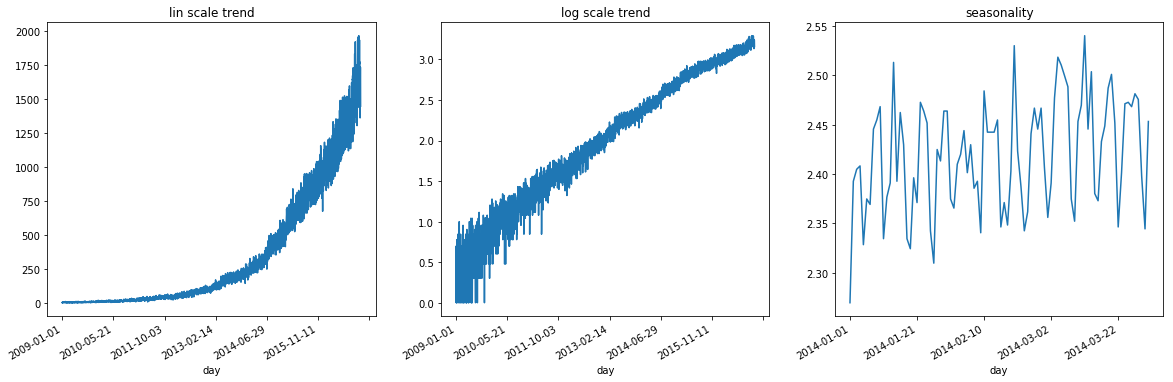

In [11]:
f, ax = plt.subplots(1, 3, figsize=(20, 6))
df.groupby('day').label.count().plot(ax=ax[0], title='lin scale trend')
df.groupby('day').label.count().apply(lambda x: np.log(x)/np.log(10)).plot(ax=ax[1], title='log scale trend')
q = df.groupby('day').label.count().apply(lambda x: np.log(x)/np.log(10)).to_frame('cnt').reset_index()
q[q.day.apply(lambda x: any(a in x for a in ['2014-01', '2014-02', '2014-03']))].set_index('day').cnt.plot(ax=ax[2], title='seasonality')
f.autofmt_xdate()

In [12]:
from statsmodels.tsa.arima_model import ARIMA

/home/artem/.conda/envs/env36/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:218: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/artem/.conda/envs/env36/lib/python3.6/site-packages/statsmodels/tsa/tsatools.py:689: RuntimeWarning: overflow encountered in exp
  newparams = ((1-np.exp(-params))/(1+np.exp(-params))).copy()
/home/artem/.conda/envs/env36/lib/python3.6/site-packages/statsmodels/tsa/tsatools.py:689: RuntimeWarning: invalid value encountered in true_divide
  newparams = ((1-np.exp(-params))/(1+np.exp(-params))).copy()
/home/artem/.conda/envs/env36/lib/python3.6/site-packages/statsmodels/tsa/tsatools.py:690: RuntimeWarning: overflow encountered in exp
  tmp = ((1-np.exp(-params))/(1+np.exp(-params))).copy()
/home/artem/.conda/envs/env36/lib/python3.6/site-packages/statsmodels/tsa/tsatools.py:690: RuntimeWarning: inval

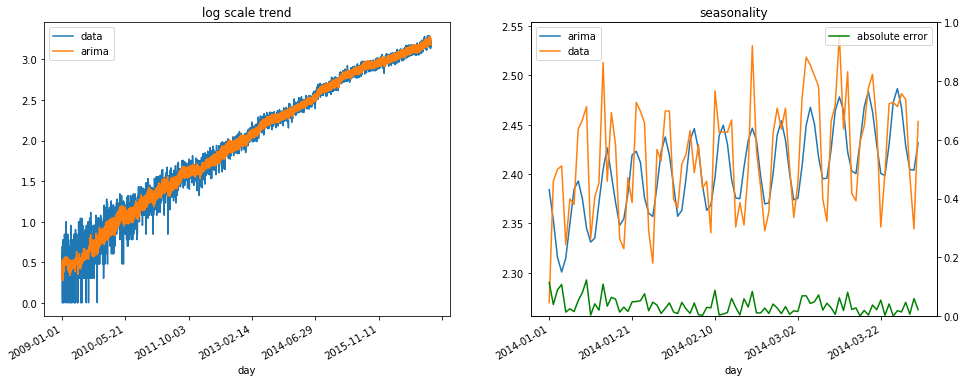

In [13]:
time_data = df.groupby('day').label.count().apply(lambda x: np.log(x)/np.log(10))
arima = ARIMA(time_data, order=(4,0,4))
res = arima.fit()
f, ax = plt.subplots(1, 2, figsize=(16, 6))
df.groupby('day').label.count().apply(lambda x: np.log(x)/np.log(10)).plot(ax=ax[0], title='log scale trend', label='data')
df.groupby('day').label.count().filter#.apply(lambda x: np.log(x)/np.log(10))
q = df.groupby('day').label.count().apply(lambda x: np.log(x)/np.log(10)).to_frame('cnt').reset_index()
mask = q.day.apply(lambda x: any(a in x for a in ['2014-01', '2014-02', '2014-03']))
ax[1].plot(res.fittedvalues.values[mask], label='arima')
q[mask].set_index('day').cnt.plot(ax=ax[1], title='seasonality', label='data')
ax[1].legend(loc='upper left')
ax[0].plot(res.fittedvalues.values[1:], label='arima')
ax[0].legend()
ax2 = ax[1].twinx()
ax2.plot(np.abs(q[mask].set_index('day').cnt.values - res.fittedvalues.values[mask]), color='green', label='absolute error')
ax2.set_ylim(0, 1)
ax2.legend(loc='upper right')
f.autofmt_xdate()
# ax[0].plot()

In [14]:
time_data = df.groupby('day').label.count().apply(lambda x: np.log(x)/np.log(10))#.values
time_data = time_data.to_frame('cnt').reset_index()
mask = time_data.day.apply(lambda x: '2016' in x)
td_train, td_test = time_data[~mask].set_index('day').cnt, time_data[mask].set_index('day').cnt

In [15]:
class BootstrapSeq:
    def __init__(self, data, window=180, steps=10):
        self.data = data.astype(np.float32)
        self.window = window
        self.steps = steps
        
    def __getitem__(self, i):
        window = self.window
        return self.data[i:i + window], self.data[i + window:i + window + self.steps]
    
    def __len__(self):
        return len(self.data) - self.window - self.steps
class SimpleRNN(pl.LightningModule):
    def __init__(self, hid=64, layers=1, steps=10):
        super().__init__()
        self.rnn = nn.LSTM(1, hid, num_layers=layers)
        self.out = nn.Linear(hid, 1)
        self.loss = nn.MSELoss(reduction='none')
        self.steps = steps
    def forward(self, x):
        preds = []
        y, hidden = self.rnn(x.t().unsqueeze(2))
        y = y[-1] 
        y = self.out(y).unsqueeze(0)
        val = x.t()[-1].unsqueeze(0) + y.squeeze(2)
        preds.append(val)
        for i in range(self.steps - 1):
            y, hidden = self.rnn(val.unsqueeze(2), hidden)
            y = self.out(y)
            val = val + y.squeeze(2)
            preds.append(val)
        y_hat = torch.cat(preds, 0)
        return y_hat.t()
    
    def l2(self):
        return sum([(p ** 2).mean() for p in self.parameters()])
    
    def compute_loss(self, batch, batch_idx, prf=''):
        x, y = batch
        y_hat = self(x)
        y = y.squeeze()
        y_hat = y_hat.squeeze()
        loss = self.loss(y_hat, y).sum(1).mean()
        mae = (y_hat - y).abs().mean()
        rmse = loss ** 0.5
        self.log(f'{prf}_mse', loss.item())
        self.log(f'{prf}_mae', mae.item())
        self.log(f'{prf}_rmse', rmse.item())
        return loss + .00001 * self.l2()
    def training_step(self, a, b):
        return self.compute_loss(a, b, 'train')
    def test_step(self, a, b):
        return self.compute_loss(a, b, 'test')
    def validation_step(self, a, b):
        return self.compute_loss(a, b, 'val')
    def configure_optimizers(self):
        opt = torch.optim.Adam(self.parameters(), lr=1e-3)
        return {
            'optimizer': opt,
            'lr_scheduler': torch.optim.lr_scheduler.StepLR(opt, step_size=20)
        }
    def forecast(self, init, steps):
        predictions = []
        st = self.steps
        self.steps = steps
        init = torch.from_numpy(np.array(init, dtype=np.float32))
        init = init.to(self.out.weight)
        preds = self(init[None, :]).detach().cpu().numpy().squeeze().tolist()
        self.steps = st
        return preds
    
rnn = SimpleRNN(256, layers=2, steps=51)
trainer = pl.Trainer(gpus=1, max_epochs=60)#callbacks=[EarlyStopping(monitor='val_mae', mode='min', patience=2)])
dl_test = DataLoader(BootstrapSeq(td_test.values, steps=51), batch_size=50, shuffle=True)
dl = DataLoader(BootstrapSeq(td_train.values, steps=51), batch_size=50, shuffle=True)
trainer.fit(rnn, dl, dl_test)

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name | Type    | Params
---------------------------------
0 | rnn  | LSTM    | 791 K 
1 | out  | Linear  | 257   
2 | loss | MSELoss | 0     


Epoch 0:   2%|▏         | 1/50 [00:00<00:04, 11.41it/s, loss=25.848, v_num=0]

/home/artem/.conda/envs/env36/lib/python3.6/site-packages/pytorch_lightning/utilities/distributed.py:45: UserWarning: Your val_dataloader has `shuffle=True`, it is best practice to turn this off for validation and test dataloaders.
  warnings.warn(*args, **kwargs)
/home/artem/.conda/envs/env36/lib/python3.6/site-packages/pytorch_lightning/utilities/distributed.py:45: UserWarning: The dataloader, val dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 16 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  warnings.warn(*args, **kwargs)
/home/artem/.conda/envs/env36/lib/python3.6/site-packages/pytorch_lightning/utilities/distributed.py:45: UserWarning: The dataloader, train dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 16 which is the number of cpus on this machine) in the `DataL

Epoch 59: 100%|██████████| 50/50 [00:04<00:00, 12.49it/s, loss=0.727, v_num=0]


1

In [16]:
rnn.steps=2
dl_test = DataLoader(BootstrapSeq(td_test.values, steps=2), batch_size=50, shuffle=True)
dl = DataLoader(BootstrapSeq(td_train.values, steps=2), batch_size=50, shuffle=True)

In [17]:
train_metrics = trainer.test(model=rnn, test_dataloaders=dl)[0]

Testing:  12%|█▎        | 6/48 [00:00<00:00, 51.34it/s]

/home/artem/.conda/envs/env36/lib/python3.6/site-packages/pytorch_lightning/utilities/distributed.py:45: UserWarning: Your test_dataloader has `shuffle=True`, it is best practice to turn this off for validation and test dataloaders.
  warnings.warn(*args, **kwargs)
/home/artem/.conda/envs/env36/lib/python3.6/site-packages/pytorch_lightning/utilities/distributed.py:45: UserWarning: The dataloader, test dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 16 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  warnings.warn(*args, **kwargs)


Testing: 100%|██████████| 48/48 [00:00<00:00, 54.39it/s]--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'test_mae': tensor(0.0992),
 'test_mse': tensor(0.0433),
 'test_rmse': tensor(0.2057),
 'train_mae': 0.09135838598012924,
 'train_mse': 0.7718736529350281,
 'train_rmse': 0.878563404083252,
 'val_mae': tensor(0.0506),
 'val_mse': tensor(0.1982),
 'val_rmse': tensor(0.4451)}
--------------------------------------------------------------------------------
Testing: 100%|██████████| 48/48 [00:00<00:00, 53.41it/s]


In [18]:
arima = ARIMA(td_train, order=(4,0,4))
res = arima.fit()
arima = ARIMA(td_train, order=(1,0,1))
res_low = arima.fit()

/home/artem/.conda/envs/env36/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:218: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/artem/.conda/envs/env36/lib/python3.6/site-packages/statsmodels/base/model.py:548: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/home/artem/.conda/envs/env36/lib/python3.6/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/home/artem/.conda/envs/env36/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:218: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWa

In [19]:
mae = np.abs(res.fittedvalues.values - td_train.values).mean()
rmse = ((res.fittedvalues.values - td_train.values) ** 2).mean() ** 0.5
mae_lin = np.abs(res_low.fittedvalues.values - td_train.values).mean()
rmse_lin = ((res_low.fittedvalues.values - td_train.values) ** 2).mean() ** 0.5
rnn_mae_train = train_metrics['test_mae']
rnn_rmse_train = train_metrics['test_rmse']

print(f'arima MAE: {mae:.4f}, arima RMSE: {rmse:.4f}')
print(f'trend model MAE: {mae_lin:.4f}, trend model RMSE: {rmse_lin:.4f}')
print(f'rnn MAE: {rnn_mae_train:.4f}, rnn RMSE: {rnn_rmse_train:.4f}')

arima MAE: 0.0788, arima RMSE: 0.1769
trend model MAE: 0.0906, trend model RMSE: 0.1321
rnn MAE: 0.0992, rnn RMSE: 0.2057


In [20]:
arima = ARIMA(td_train, order=(10,1,4))
res_hi = arima.fit()
mean, se, conf = res_hi.forecast(100)

/home/artem/.conda/envs/env36/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:218: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/artem/.conda/envs/env36/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:218: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/artem/.conda/envs/env36/lib/python3.6/site-packages/statsmodels/base/model.py:548: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/home/artem/.conda/envs/env36/lib/python3.6/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWa

In [21]:
nn_fc = rnn.forecast(td_train.values[-180:], 100)

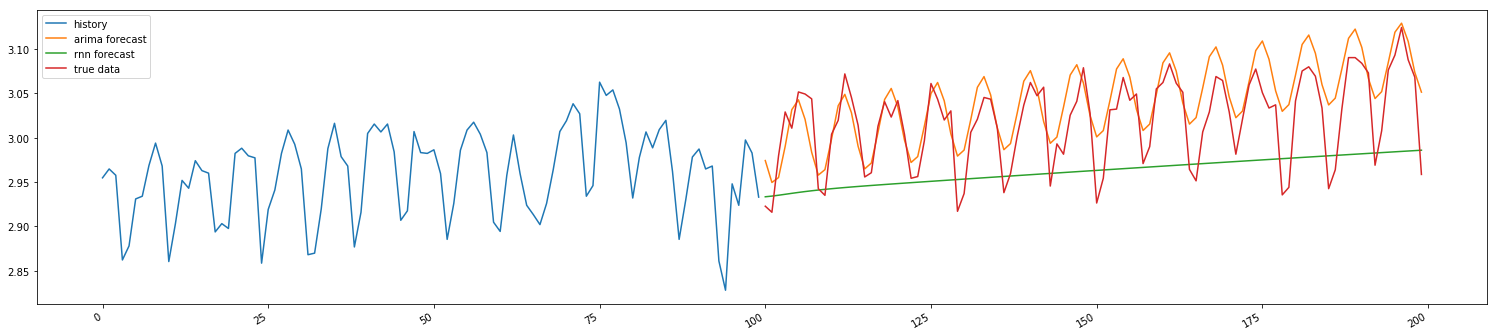

In [22]:
f = plt.figure(figsize=(26, 6))
plt.plot(np.arange(100), td_train.iloc[-100:].values, label='history')
plt.plot(np.arange(100, 200), mean, label='arima forecast')
plt.plot(np.arange(100, 200), nn_fc, label='rnn forecast')
plt.plot(np.arange(100, 200),td_test.iloc[:100].values, label='true data')
plt.legend()
f.autofmt_xdate()

In [23]:
nn_mae = np.abs(nn_fc - td_test.iloc[:100].values).mean()
nn_rmse = np.sqrt(((nn_fc - td_test.iloc[:100].values) ** 2).mean())
arima_mae = np.abs(mean - td_test.iloc[:100].values).mean()
arima_rmse = np.sqrt(((mean - td_test.iloc[:100].values) ** 2).mean())

In [24]:
print(f'rnn forecast MAE {nn_mae:.4f}, rnn forecast RMSE {nn_rmse:.4f}')
print(f'arima forecast MAE {arima_mae:.4f}, arima forecast RMSE {arima_rmse:.4f}')

rnn forecast MAE 0.0639, rnn forecast RMSE 0.0731
arima forecast MAE 0.0300, arima forecast RMSE 0.0375


In [25]:
time_data = time_data.set_index('day').cnt
arima = ARIMA(time_data, order=(10,0,4))
res = arima.fit()
arima_lo = ARIMA(time_data, order=(1,0,1))
res_lo = arima_lo.fit()

/home/artem/.conda/envs/env36/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:218: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/artem/.conda/envs/env36/lib/python3.6/site-packages/statsmodels/base/model.py:548: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/home/artem/.conda/envs/env36/lib/python3.6/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/home/artem/.conda/envs/env36/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:218: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWa

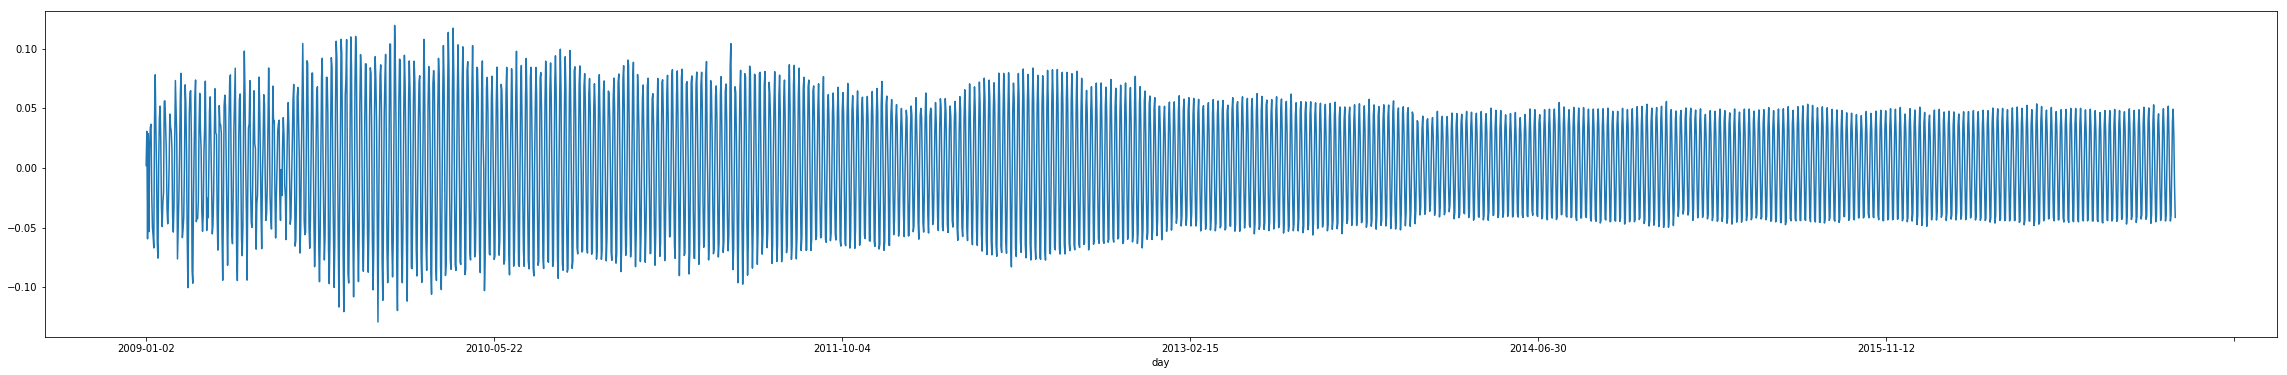

In [26]:
plt.figure(figsize=(40, 6))
(res.fittedvalues[1:] - res_lo.fittedvalues[1:]).plot(alpha=1)

In [27]:
%%time
pipeline = wrappers.FeaturePipeline(tokenizer='bpe', postprocessor='none', vectorizer='tfidf',  
                                    vectorizer_max_df=0.99, vectorizer_min_df=0.0001)
X = pipeline.fit_transform(df['comment'].values)

[nltk_data] Downloading package wordnet to /home/artem/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to /home/artem/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
/home/artem/.conda/envs/env36/lib/python3.6/site-packages/sklearn/feature_extraction/text.py:386: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ["'", 'b', 'c', 'e', 'f', 'g', 'h', 'j', 'l', 'n', 'p', 'r', 'u', 'v', 'w'] not in stop_words.
  'stop_words.' % sorted(inconsistent))


CPU times: user 1min, sys: 1.68 s, total: 1min 2s
Wall time: 48 s


In [28]:
y = df['label'].values
X_train, X_test, y_train, y_test, train, test = train_test_split(X, y, np.arange(X.shape[0]), test_size=0.2)

In [29]:
def calc_metrics(model, X_test, y_test, X_train, y_train):
    y_pred_test = model.predict(X_test)
    y_pred_train = model.predict(X_train)
    metrics = [f1_score, accuracy_score, precision_score, recall_score, roc_auc_score]
    names = ['f1', 'acc', 'precision', 'recall', 'roc_auc']
    res = {}
    for m, n in zip(metrics, names):
        res[f'train_{n}'] = m(y_train, y_pred_train)
        res[f'test_{n}'] = m(y_test, y_pred_test)
    return res

In [30]:
lc = LogisticRegression(solver='liblinear',  C=1.)
lc.fit(X_train, y_train)
lr_simple = calc_metrics(lc, X_test, y_test, X_train, y_train)
print(lr_simple)

{'train_f1': 0.7457382543063612, 'test_f1': 0.7214423327524618, 'train_acc': 0.7533285185340916, 'test_acc': 0.7303603670450891, 'train_precision': 0.7698490610730218, 'test_precision': 0.7442824154619935, 'train_recall': 0.7230918313870128, 'test_recall': 0.699962318035778, 'train_roc_auc': 0.7533446060972243, 'test_roc_auc': 0.7302903060996472}


In [31]:
xgb = XGBClassifier(n_estimators=1000, max_depth=5, n_jobs=16)
xgb.fit(X_train, y_train)
xgb_simple = calc_metrics(xgb, X_test, y_test, X_train, y_train)
print(xgb_simple)

{'train_f1': 0.747627751959942, 'test_f1': 0.7108337350929521, 'train_acc': 0.7642038638763916, 'test_acc': 0.7300042046944176, 'train_precision': 0.8046515073379622, 'test_precision': 0.7631300549431799, 'train_recall': 0.6981514075802672, 'test_recall': 0.6652453294196977, 'train_roc_auc': 0.7642390073779126, 'test_roc_auc': 0.7298549494568162}


In [32]:
Xf = scipy.sparse.hstack([X_train, scipy.sparse.csr_matrix(df.iloc[train][['score', 'ups', 'downs']].values, dtype=np.float32)]).tocsr()

In [33]:
Xft = scipy.sparse.hstack([X_test, scipy.sparse.csr_matrix(df.iloc[test][['score', 'ups', 'downs']].values, dtype=np.float32)]).tocsr()

In [34]:
lc = LogisticRegression(solver='liblinear',  C=1.)
lc.fit(Xf, y_train)
lr_updown = calc_metrics(lc, Xft, y_test, Xf, y_train)
print(lr_updown)

{'train_f1': 0.7468700990790249, 'test_f1': 0.721476252981465, 'train_acc': 0.7542857072189835, 'test_acc': 0.730241646261532, 'train_precision': 0.7705471799792326, 'test_precision': 0.7438730265721598, 'train_recall': 0.724604720609902, 'test_recall': 0.7003887192098687, 'train_roc_auc': 0.7543014991191873, 'test_roc_auc': 0.7301728417046076}


In [35]:
xgb = XGBClassifier(n_estimators=1000, max_depth=5, n_jobs=16)
xgb.fit(Xf, y_train)
xgb_updown = calc_metrics(xgb, Xft, y_test, Xf, y_train)
print(xgb_updown)

{'train_f1': 0.7529283760095242, 'test_f1': 0.7164061432370782, 'train_acc': 0.7674773502444913, 'test_acc': 0.733095891766219, 'train_precision': 0.8036681085508783, 'test_precision': 0.7621960766770305, 'train_recall': 0.7082150873619365, 'test_recall': 0.6758061957082226, 'train_roc_auc': 0.7675088809935737, 'test_roc_auc': 0.7329638513754466}


In [36]:
df1 = pd.merge((res.fittedvalues[1:] - res_lo.fittedvalues[1:]).to_frame('season').reset_index(), df, how='right')

In [37]:
df1.loc[df1.season.isna(), 'season'] = 0.

In [38]:
Xf1 = scipy.sparse.hstack([Xf, scipy.sparse.csr_matrix(df1.iloc[train].season.values[:, None], dtype=np.float32)]).tocsr()
Xft1 = scipy.sparse.hstack([Xft, scipy.sparse.csr_matrix(df1.iloc[test].season.values[:, None], dtype=np.float32)]).tocsr()

In [39]:
lc = LogisticRegression(solver='liblinear',  C=1, penalty='l2')
lc.fit(Xf1, y_train)
lr_season = calc_metrics(lc, Xft1, y_test, Xf1, y_train)
print(lr_season)

{'train_f1': 0.746859326091194, 'test_f1': 0.7215075453872277, 'train_acc': 0.754270867084334, 'test_acc': 0.730241646261532, 'train_precision': 0.7705214513470673, 'test_precision': 0.7438165334681113, 'train_recall': 0.7246071926511158, 'test_recall': 0.700497798579985, 'train_roc_auc': 0.754286649773518, 'test_roc_auc': 0.7301730931090249}


In [41]:
xgb = XGBClassifier(n_estimators=1000, max_depth=5, n_jobs=16)
xgb.fit(Xf1, y_train)
xgb_season = calc_metrics(xgb, Xft1, y_test, Xf1, y_train)
print(xgb_season)

{'train_f1': 0.782812131820783, 'test_f1': 0.747372352898453, 'train_acc': 0.792544811023252, 'test_acc': 0.7591155301624991, 'train_precision': 0.8218252695333526, 'test_precision': 0.7836782209456666, 'train_recall': 0.7473351395714469, 'test_recall': 0.7142814644401253, 'train_roc_auc': 0.7925688650289094, 'test_roc_auc': 0.7590121973126982}


In [50]:
res = pd.DataFrame.from_records([lr_simple, xgb_simple, lr_updown, xgb_updown, lr_season, xgb_season])
res['model'] = ['logreg', 'xgb'] * 3
res['data'] = ['simple', 'simple', 'updown', 'updown', 'season', 'season']
res.set_index(['model', 'data']).sort_values('test_f1', ascending=False)

train_f1   test_f1  train_acc  test_acc  train_precision  \
model  data                                                               
xgb    season  0.782812  0.747372   0.792545  0.759116         0.821825   
logreg season  0.746859  0.721508   0.754271  0.730242         0.770521   
       updown  0.746870  0.721476   0.754286  0.730242         0.770547   
       simple  0.745738  0.721442   0.753329  0.730360         0.769849   
xgb    updown  0.752928  0.716406   0.767477  0.733096         0.803668   
       simple  0.747628  0.710834   0.764204  0.730004         0.804652   

               test_precision  train_recall  test_recall  train_roc_auc  \
model  data                                                               
xgb    season        0.783678      0.747335     0.714281       0.792569   
logreg season        0.743817      0.724607     0.700498       0.754287   
       updown        0.743873      0.724605     0.700389       0.754301   
       simple        0.744282      0.723092     0.699962       0.753345   
xgb    updown        0.762196      0.708215     0.675806       0.767509   
       simple        0.763130      0.698151     0.665245       0.764239   

               test_roc_auc  
model  data                  
xgb    season      0.759012  
logreg season      0.730173  
       updown      0.730173  
       simple      0.730290  
xgb    updown      0.732964  
       simple      0.729855

In [51]:
%%time
xgb = XGBClassifier(n_estimators=2000, max_depth=10, n_jobs=16)
xgb.fit(Xf1, y_train)
xgb_season2 = calc_metrics(xgb, Xft1, y_test, Xf1, y_train)
xgb_season2

CPU times: user 7h 37min 35s, sys: 1h 41min 30s, total: 9h 19min 6s
Wall time: 35min 54s


{'train_f1': 0.904720187297032,
 'test_f1': 0.777911200960647,
 'train_acc': 0.9063884306310273,
 'test_acc': 0.7831713289307709,
 'train_precision': 0.9216435517623405,
 'test_precision': 0.7953233944241269,
 'train_recall': 0.88840711552343,
 'test_recall': 0.7612450914283447,
 'train_roc_auc': 0.9063979976692613,
 'test_roc_auc': 0.7831207936832971}